In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.utils import resample
from scipy import stats
import joblib
import os
os.makedirs("models", exist_ok=True)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)






In [148]:
df = pd.read_csv("../data/raw/gold_price.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-10-01,2631.399902,2670.899902,2631.399902,2667.300049,153,0.0,0.0
1,2024-10-02,2650.600098,2657.199951,2640.000000,2647.100098,72,0.0,0.0
2,2024-10-03,2642.800049,2657.100098,2640.000000,2657.100098,354,0.0,0.0
3,2024-10-04,2656.000000,2667.000000,2639.000000,2645.800049,114,0.0,0.0
4,2024-10-07,2648.699951,2657.399902,2639.000000,2644.800049,284,0.0,0.0


In [149]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          253 non-null    datetime64[ns]
 1   Open          253 non-null    float64       
 2   High          253 non-null    float64       
 3   Low           253 non-null    float64       
 4   Close         253 non-null    float64       
 5   Volume        253 non-null    int64         
 6   Dividends     253 non-null    float64       
 7   Stock Splits  253 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 15.9 KB


In [150]:
df.describe()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,253,253.000000,253.000000,253.000000,253.000000,253.000000,253.0,253.0
mean,2025-04-01 18:58:20.395256832,3069.980628,3089.581026,3053.394858,3073.330434,5370.205534,0.0,0.0
min,2024-10-01 00:00:00,2555.100098,2565.699951,2554.199951,2565.699951,0.000000,0.0,0.0
25%,2024-12-31 00:00:00,2729.000000,2737.100098,2719.500000,2733.800049,197.000000,0.0,0.0
50%,2025-04-02 00:00:00,3069.699951,3094.899902,3034.399902,3060.199951,652.000000,0.0,0.0
75%,2025-07-03 00:00:00,3344.000000,3357.500000,3329.000000,3340.100098,1728.000000,0.0,0.0
max,2025-10-01 00:00:00,3887.699951,3922.699951,3880.300049,3888.600098,228154.000000,0.0,0.0
std,NaN,342.632938,347.503563,340.296504,345.115577,24012.252939,0.0,0.0


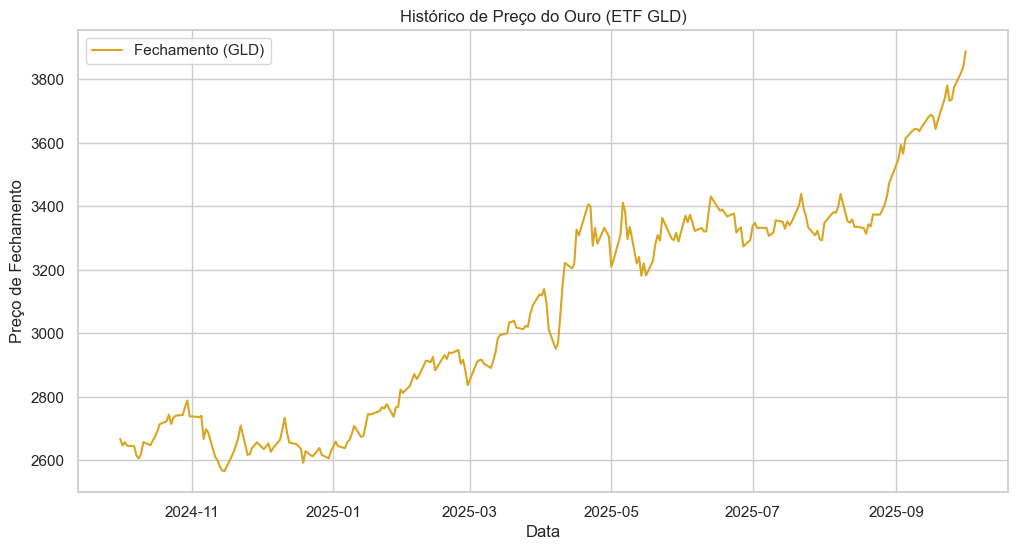

In [151]:
plt.plot(df["Date"], df["Close"], label="Fechamento (GLD)", color="goldenrod")
plt.title("Histórico de Preço do Ouro (ETF GLD)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()


In [152]:
# Cria a variável target: se o preço de amanhã for maior que o de hoje
df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Verificar distribuição
df["target"].value_counts(normalize=True)


target
1    0.58498
0    0.41502
Name: proportion, dtype: float64

In [153]:
# Se amanhã for maior que hoje → 1 (sobe)
# Se for igual ou menor → 0 (não sobe)
df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)


In [154]:
# Feature: variação percentual
df["pct_change"] = df["Close"].pct_change()

# Médias móveis (SMA)
df["sma_3"] = df["Close"].rolling(window=3).mean()
df["sma_7"] = df["Close"].rolling(window=7).mean()

# Volatilidade curta
df["std_3"] = df["Close"].rolling(window=3).std()

# Momentum simples
df["momentum"] = df["Close"] - df["Close"].shift(1)

# Drop nas linhas com NaN geradas pelas janelas
df.dropna(inplace=True)

df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,pct_change,sma_3,sma_7,std_3,momentum
6,2024-10-09,2603.000000,2607.699951,2603.000000,2606.000000,152,0.0,0.0,1,-0.003442,2621.933350,2640.442906,20.307990,-9.000000
7,2024-10-10,2602.500000,2628.300049,2602.500000,2620.600098,320,0.0,0.0,1,0.005602,2613.866699,2633.771484,7.365731,14.600098
8,2024-10-11,2638.300049,2658.100098,2638.199951,2657.600098,12,0.0,0.0,0,0.014119,2628.066732,2635.271484,26.598035,37.000000
9,2024-10-14,2655.000000,2655.300049,2647.800049,2647.800049,40,0.0,0.0,1,-0.003688,2642.000081,2633.942906,19.169760,-9.800049
10,2024-10-15,2661.399902,2661.399902,2661.399902,2661.399902,39,0.0,0.0,1,0.005136,2655.600016,2636.171456,7.017068,13.599854


In [155]:
# Features e target
features = ["pct_change", "sma_3", "sma_7", "std_3", "momentum"]
X = df[features]
y = df["target"]

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.38
              precision    recall  f1-score   support

           0       0.33      0.63      0.44        19
           1       0.50      0.23      0.31        31

    accuracy                           0.38        50
   macro avg       0.42      0.43      0.37        50
weighted avg       0.44      0.38      0.36        50



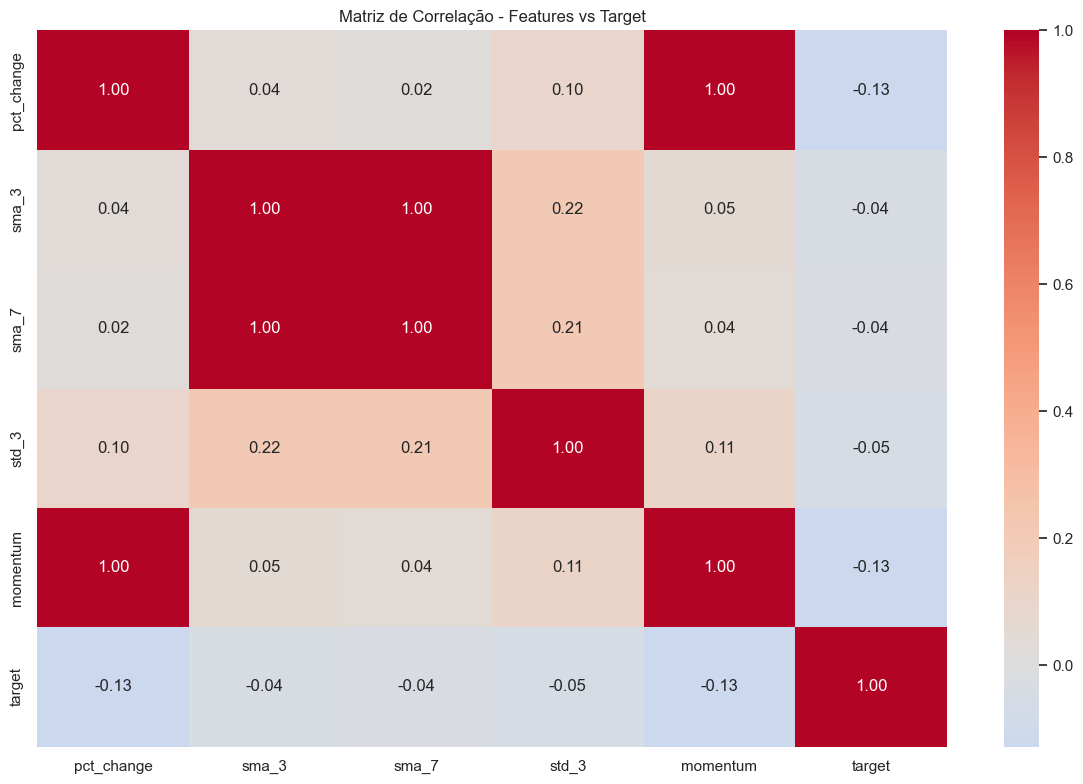


Correlação das Features com o Target (ordenada):
target        1.000000
sma_7        -0.035169
sma_3        -0.038270
std_3        -0.047341
pct_change   -0.125106
momentum     -0.128025
Name: target, dtype: float64


In [156]:
# Análise de Correlação entre Features
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ["target"]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlação - Features vs Target")
plt.tight_layout()
plt.show()

# Mostrar correlação com o target especificamente
print("\nCorrelação das Features com o Target (ordenada):")
print(correlation_matrix["target"].sort_values(ascending=False))

In [157]:
# Re-treinar o modelo com balanceamento
modelo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
modelo.fit(X_train, y_train)

# Previsões com ajuste de threshold
probas = modelo.predict_proba(X_test)[:,1]
y_pred = (probas > 0.6).astype(int)  # 0.6 em vez de 0.5

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.40      0.89      0.56        19
           1       0.75      0.19      0.31        31

    accuracy                           0.46        50
   macro avg       0.58      0.54      0.43        50
weighted avg       0.62      0.46      0.40        50



In [158]:
# Cruzamento de médias móveis: quando a média curta cruza acima da longa
df["cross_sma"] = (df["sma_3"] > df["sma_7"]).astype(int)


In [159]:
# Cruzamento de médias móveis: quando a média curta cruza acima da longa
df["cross_sma"] = (df["sma_3"] > df["sma_7"]).astype(int)


In [160]:
df["prev_up"] = ((df["Close"].diff().shift(1)) > 0).astype(int)



In [161]:
# Recria todas as features com segurança

# Variação percentual
df["pct_change"] = df["Close"].pct_change()

# Médias móveis
df["sma_3"] = df["Close"].rolling(window=3).mean()
df["sma_7"] = df["Close"].rolling(window=7).mean()

# Volatilidade curta
df["std_3"] = df["Close"].rolling(window=3).std()

# Momentum
df["momentum"] = df["Close"] - df["Close"].shift(1)

# Cruzamento de médias móveis
df["cross_sma"] = (df["sma_3"] > df["sma_7"]).astype(int)

# Candle anterior positivo
prev_diff = df["Close"].diff().shift(1)
df["prev_up"] = (prev_diff > 0).astype(int)

# Amplitude da vela
df["amplitude"] = df["High"] - df["Low"]

# Candle de alta
df["candle_alta"] = (df["Close"] > df["Open"]).astype(int)

# Fechamento de 2 dias atrás
df["close_2_days_ago"] = df["Close"].shift(2)

# Volatilidade de 7 dias
df["rolling_std_7"] = df["Close"].rolling(window=7).std()

# Target
df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Remover NaNs
df.dropna(inplace=True)

# Definir lista final de features
features = [
    "pct_change", "sma_3", "sma_7", "std_3", "momentum",
    "cross_sma", "prev_up", "amplitude", "candle_alta",
    "close_2_days_ago", "rolling_std_7"
]



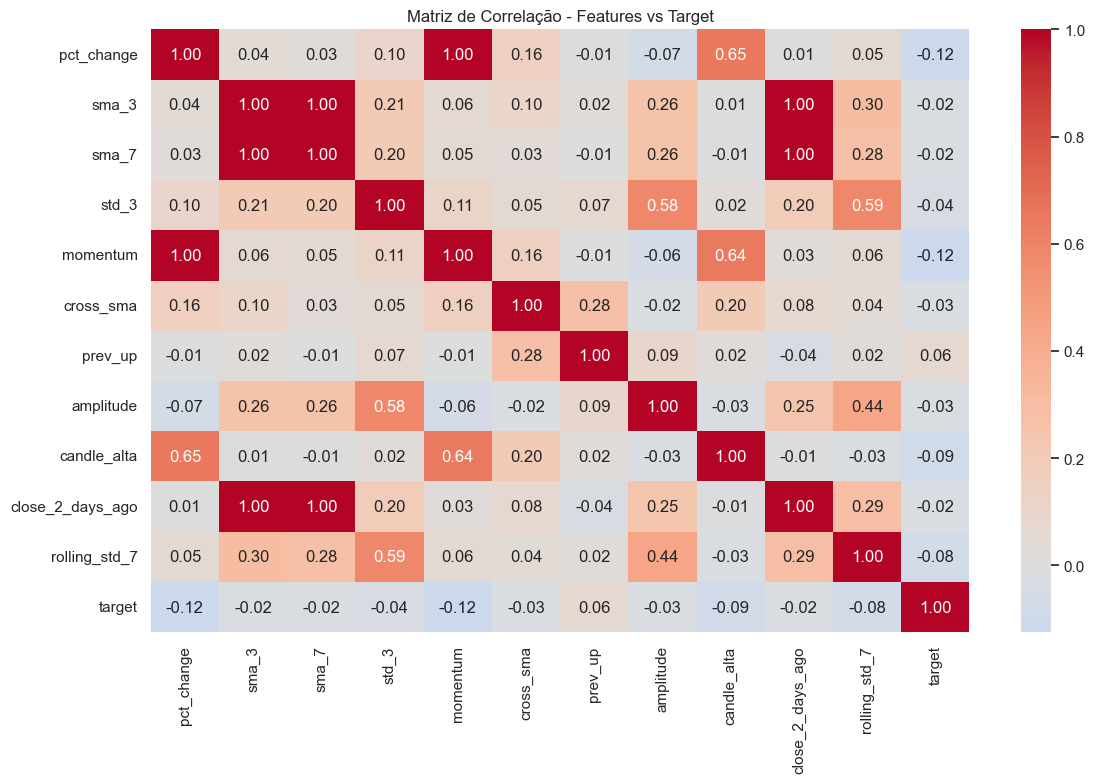


Correlação das Features com o Target (ordenada):
target              1.000000
prev_up             0.064263
sma_7              -0.020136
close_2_days_ago   -0.021173
sma_3              -0.023469
amplitude          -0.026226
cross_sma          -0.026660
std_3              -0.036231
rolling_std_7      -0.079353
candle_alta        -0.087306
pct_change         -0.121522
momentum           -0.124957
Name: target, dtype: float64


In [162]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ["target"]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlação - Features vs Target")
plt.tight_layout()
plt.show()

# Mostrar correlação com o target especificamente
print("\nCorrelação das Features com o Target (ordenada):")
print(correlation_matrix["target"].sort_values(ascending=False))

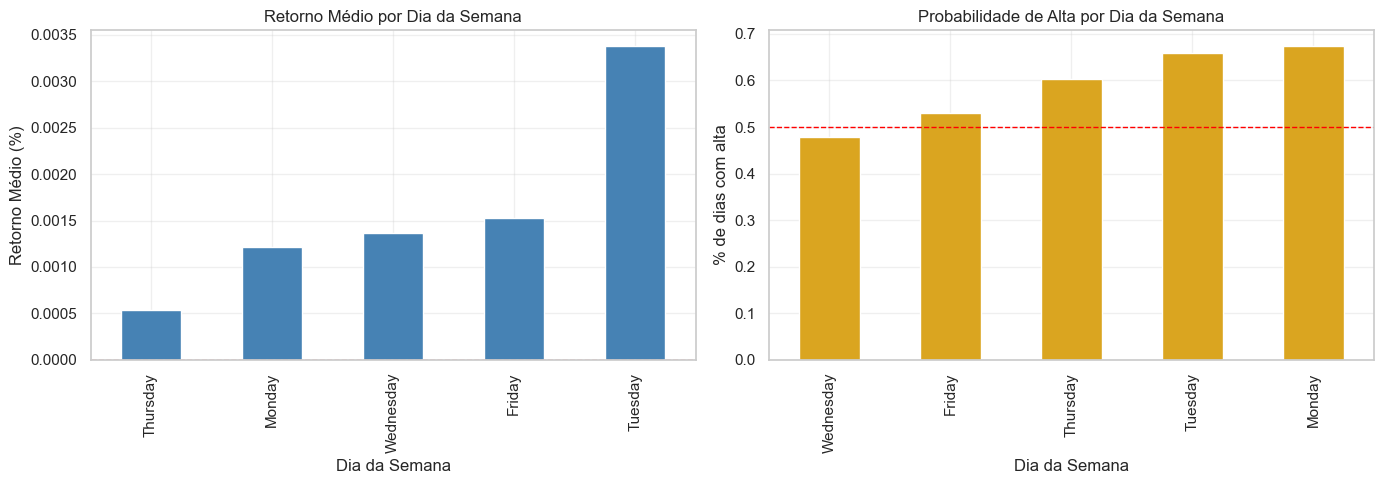

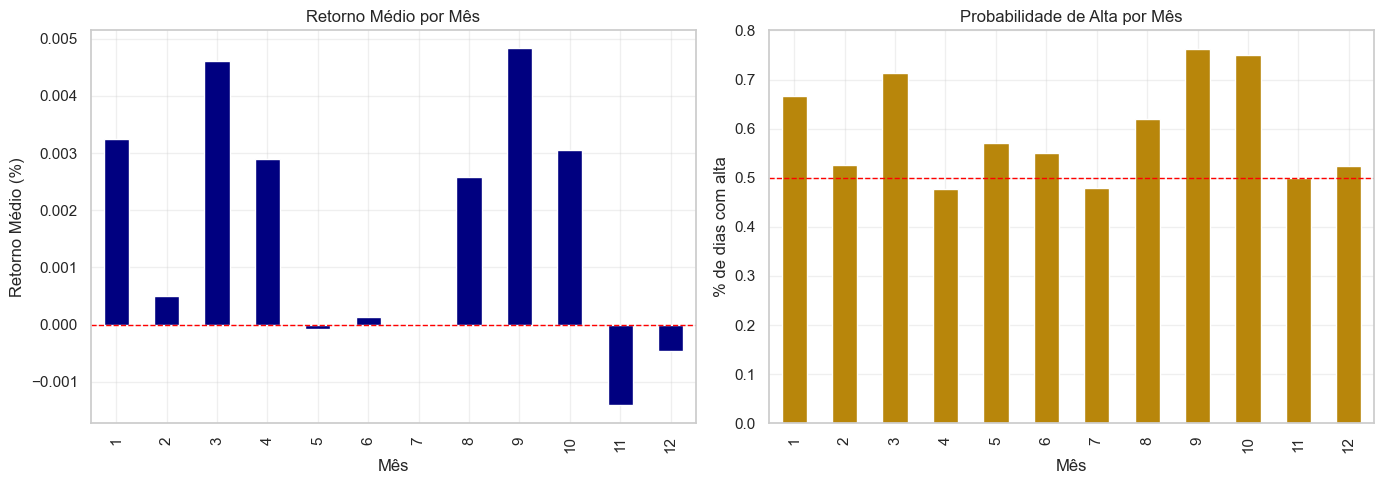

Insights de Sazonalidade:
Melhor dia da semana para comprar: Tuesday
Pior dia da semana: Thursday
Melhor mês: 9
Pior mês: 11


In [163]:
# Análise de Sazonalidade - Dia da Semana e Mês
df_sazonal = df.copy()
df_sazonal["dia_semana"] = df_sazonal["Date"].dt.dayofweek  # 0=Segunda, 4=Sexta
df_sazonal["mes"] = df_sazonal["Date"].dt.month
df_sazonal["nome_dia"] = df_sazonal["Date"].dt.day_name()

# Análise por dia da semana
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retorno médio por dia da semana
retorno_por_dia = df_sazonal.groupby("nome_dia")["pct_change"].mean().sort_values()
retorno_por_dia.plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("Retorno Médio por Dia da Semana")
axes[0].set_xlabel("Dia da Semana")
axes[0].set_ylabel("Retorno Médio (%)")
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Frequência de alta por dia da semana
target_por_dia = df_sazonal.groupby("nome_dia")["target"].mean().sort_values()
target_por_dia.plot(kind="bar", ax=axes[1], color="goldenrod")
axes[1].set_title("Probabilidade de Alta por Dia da Semana")
axes[1].set_xlabel("Dia da Semana")
axes[1].set_ylabel("% de dias com alta")
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise por mês
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retorno médio por mês
retorno_por_mes = df_sazonal.groupby("mes")["pct_change"].mean()
retorno_por_mes.plot(kind="bar", ax=axes[0], color="navy")
axes[0].set_title("Retorno Médio por Mês")
axes[0].set_xlabel("Mês")
axes[0].set_ylabel("Retorno Médio (%)")
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Frequência de alta por mês
target_por_mes = df_sazonal.groupby("mes")["target"].mean()
target_por_mes.plot(kind="bar", ax=axes[1], color="darkgoldenrod")
axes[1].set_title("Probabilidade de Alta por Mês")
axes[1].set_xlabel("Mês")
axes[1].set_ylabel("% de dias com alta")
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Insights de Sazonalidade:")
print(f"Melhor dia da semana para comprar: {retorno_por_dia.idxmax()}")
print(f"Pior dia da semana: {retorno_por_dia.idxmin()}")
print(f"Melhor mês: {retorno_por_mes.idxmax()}")
print(f"Pior mês: {retorno_por_mes.idxmin()}")

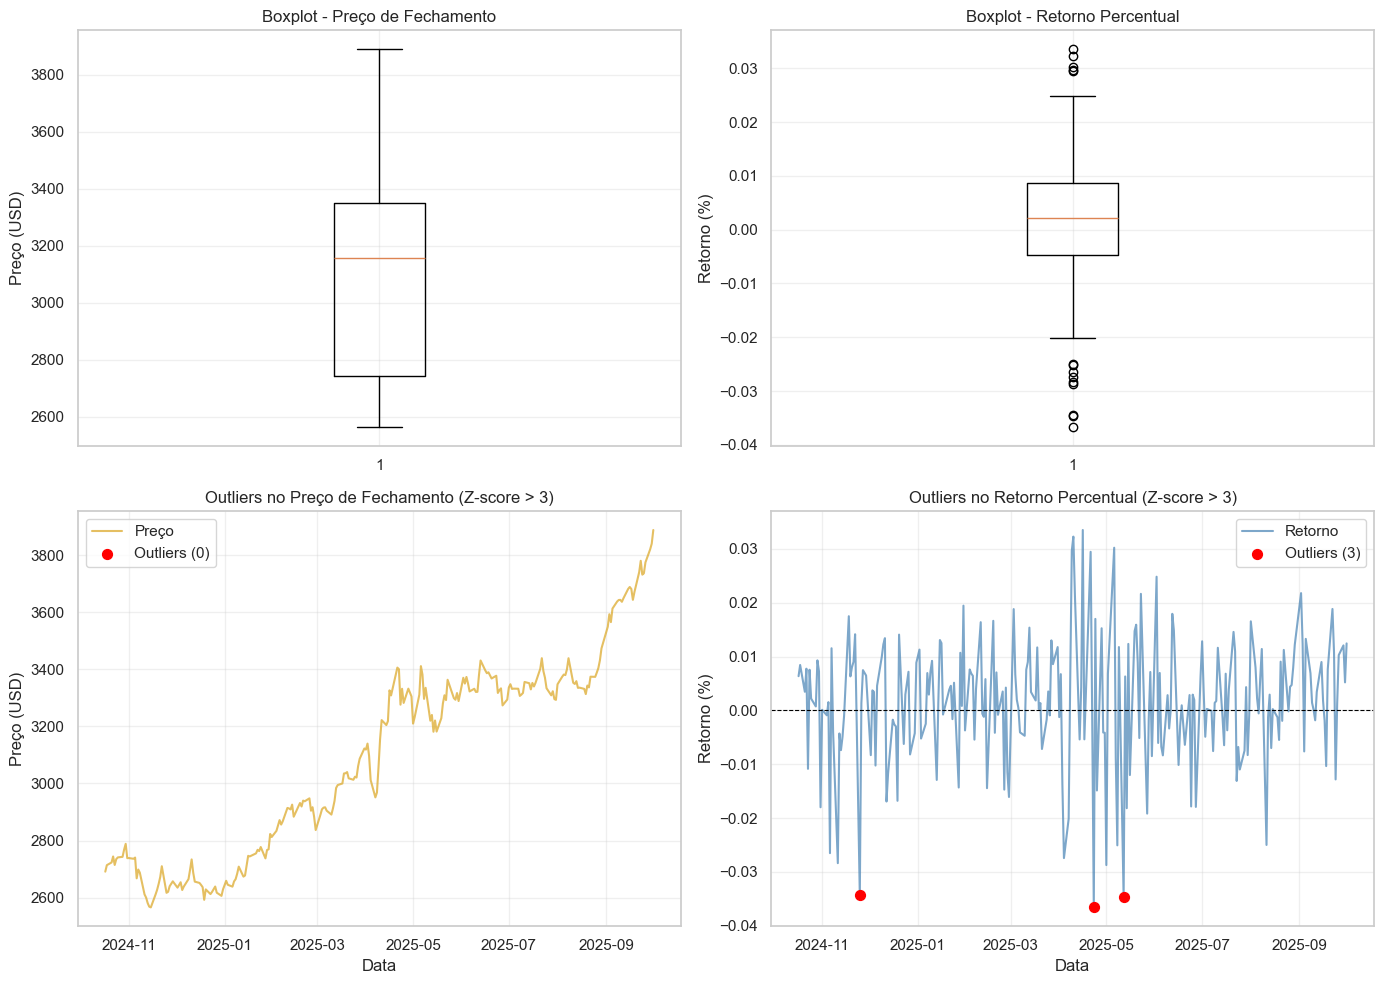

ANÁLISE DE OUTLIERS

Outliers no Preço: 0 dias

Outliers no Retorno: 3 dias
Maior queda: -3.66% em 2025-04-23
Maior alta: -3.44% em 2024-11-25


In [164]:
# Detecção de Outliers usando Boxplot e Z-Score

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot do preço de fechamento
axes[0, 0].boxplot(df["Close"], vert=True)
axes[0, 0].set_title("Boxplot - Preço de Fechamento")
axes[0, 0].set_ylabel("Preço (USD)")
axes[0, 0].grid(True, alpha=0.3)

# Boxplot do retorno percentual
axes[0, 1].boxplot(df["pct_change"].dropna(), vert=True)
axes[0, 1].set_title("Boxplot - Retorno Percentual")
axes[0, 1].set_ylabel("Retorno (%)")
axes[0, 1].grid(True, alpha=0.3)

# Série temporal com outliers marcados (preço)
z_scores_price = np.abs(stats.zscore(df["Close"]))
outliers_price = df[z_scores_price > 3]
axes[1, 0].plot(df["Date"], df["Close"], label="Preço", color="goldenrod", alpha=0.7)
axes[1, 0].scatter(outliers_price["Date"], outliers_price["Close"], 
                   color='red', s=50, label=f'Outliers ({len(outliers_price)})', zorder=5)
axes[1, 0].set_title("Outliers no Preço de Fechamento (Z-score > 3)")
axes[1, 0].set_xlabel("Data")
axes[1, 0].set_ylabel("Preço (USD)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Série temporal com outliers marcados (retorno)
z_scores_ret = np.abs(stats.zscore(df["pct_change"].dropna()))
outliers_ret = df.dropna(subset=["pct_change"])[z_scores_ret > 3]
axes[1, 1].plot(df["Date"], df["pct_change"], label="Retorno", color="steelblue", alpha=0.7)
axes[1, 1].scatter(outliers_ret["Date"], outliers_ret["pct_change"], 
                   color='red', s=50, label=f'Outliers ({len(outliers_ret)})', zorder=5)
axes[1, 1].set_title("Outliers no Retorno Percentual (Z-score > 3)")
axes[1, 1].set_xlabel("Data")
axes[1, 1].set_ylabel("Retorno (%)")
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos outliers
print("ANÁLISE DE OUTLIERS")
print(f"\nOutliers no Preço: {len(outliers_price)} dias")
if len(outliers_price) > 0:
    print(f"Datas: {outliers_price['Date'].dt.date.tolist()}")
    
print(f"\nOutliers no Retorno: {len(outliers_ret)} dias")
if len(outliers_ret) > 0:
    print(f"Maior queda: {outliers_ret['pct_change'].min():.2%} em {outliers_ret[outliers_ret['pct_change'] == outliers_ret['pct_change'].min()]['Date'].dt.date.values[0]}")
    print(f"Maior alta: {outliers_ret['pct_change'].max():.2%} em {outliers_ret[outliers_ret['pct_change'] == outliers_ret['pct_change'].max()]['Date'].dt.date.values[0]}")

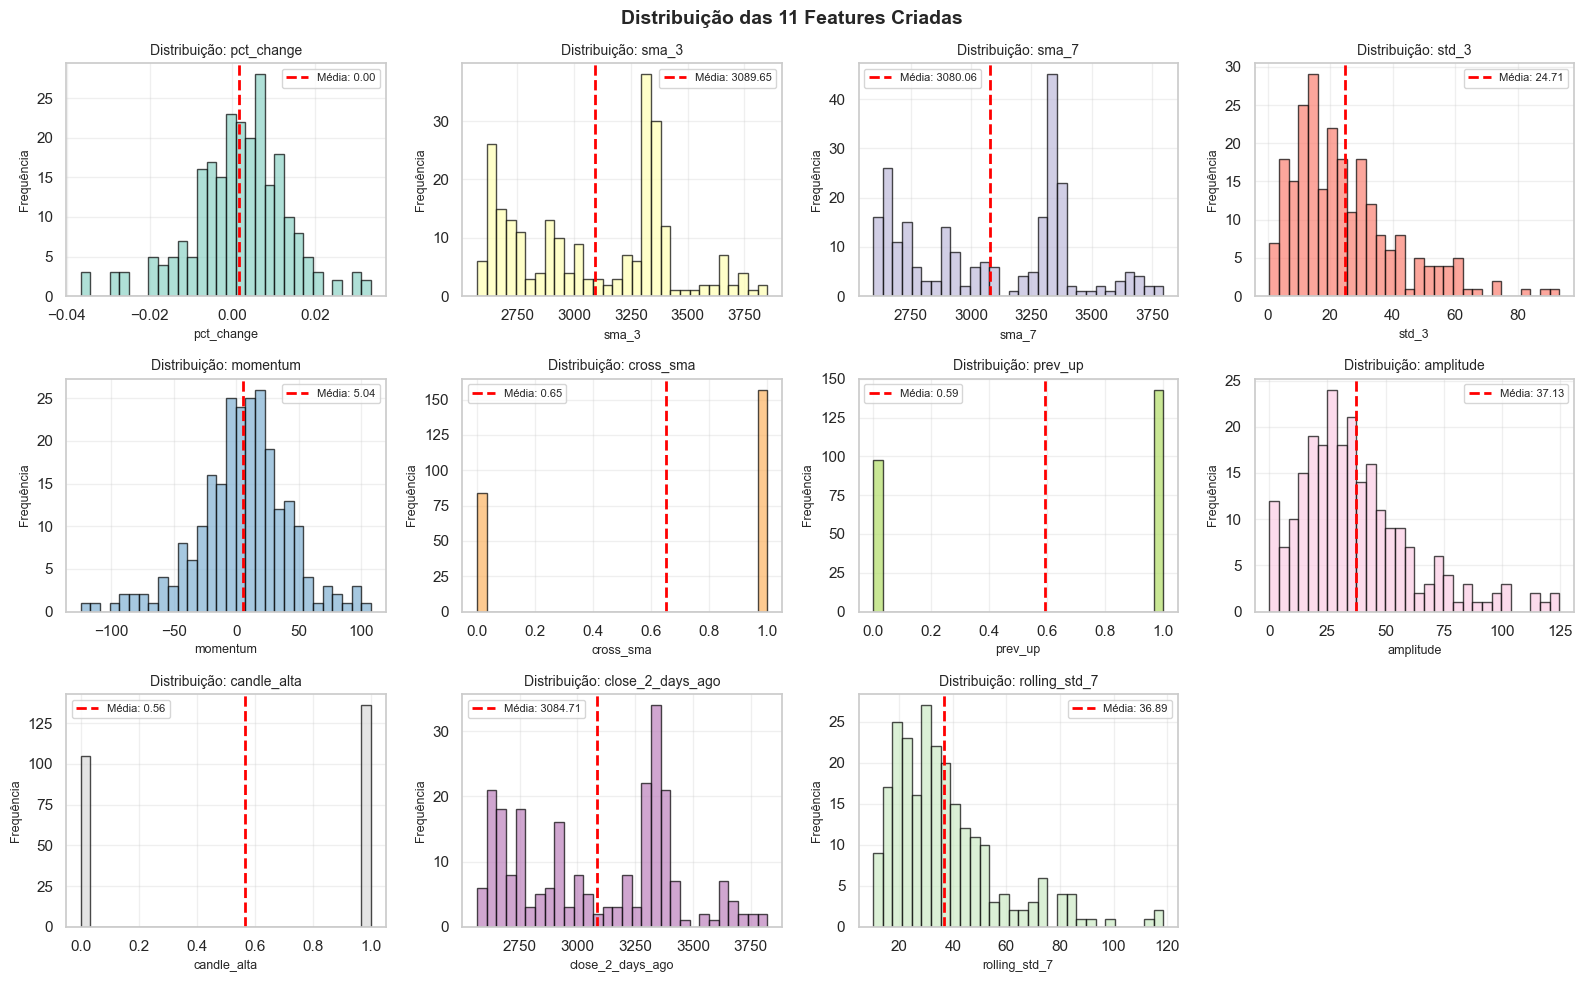

ESTATÍSTICAS DAS FEATURES
                  count         mean         std          min          25%  \
pct_change        241.0     0.001623    0.011661    -0.036609    -0.004716   
sma_3             241.0  3089.648268  336.190892  2571.566650  2748.566650   
sma_7             241.0  3080.063957  330.744254  2594.800014  2738.399937   
std_3             241.0    24.714132   17.138266     0.458199    12.449950   
momentum          241.0     5.039834   36.601755  -124.500000   -13.699951   
cross_sma         241.0     0.651452    0.477502     0.000000     0.000000   
prev_up           241.0     0.593361    0.492229     0.000000     0.000000   
amplitude         241.0    37.125727   24.799396     0.000000    19.800049   
candle_alta       241.0     0.564315    0.496878     0.000000     0.000000   
close_2_days_ago  241.0  3084.705805  334.514587  2565.699951  2740.899902   
rolling_std_7     241.0    36.888084   19.976857    10.262711    22.573010   

                          50%        

In [165]:
# Distribuições das Features Criadas
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# Cores para os histogramas
cores = plt.cm.Set3(range(len(features)))

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=30, color=cores[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f"Distribuição: {feature}", fontsize=10)
    axes[i].set_xlabel(feature, fontsize=9)
    axes[i].set_ylabel("Frequência", fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar linha vertical na média
    media = df[feature].mean()
    axes[i].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.2f}')
    axes[i].legend(fontsize=8)

# Remover o último subplot 
fig.delaxes(axes[-1])

plt.suptitle("Distribuição das 11 Features Criadas", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Estatísticas resumidas
print("ESTATÍSTICAS DAS FEATURES")
print(df[features].describe().T)

In [166]:
X = df[features]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

modelo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
modelo.fit(X_train, y_train)

probas = modelo.predict_proba(X_test)[:, 1]
y_pred = (probas > 0.55).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.4489795918367347
              precision    recall  f1-score   support

           0       0.38      0.78      0.51        18
           1       0.67      0.26      0.37        31

    accuracy                           0.45        49
   macro avg       0.52      0.52      0.44        49
weighted avg       0.56      0.45      0.42        49



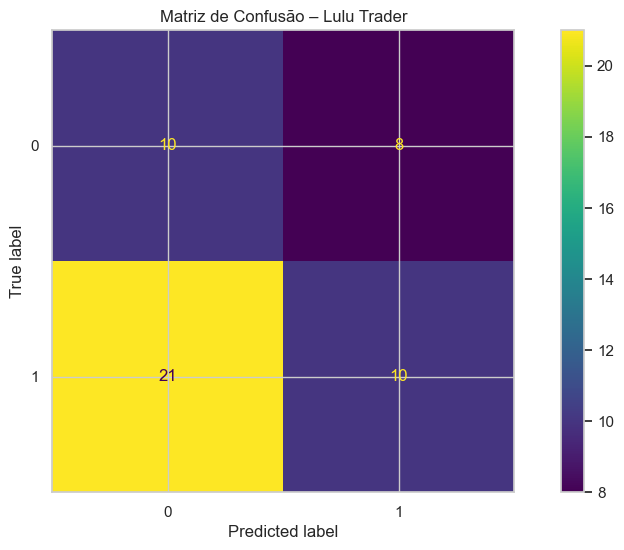

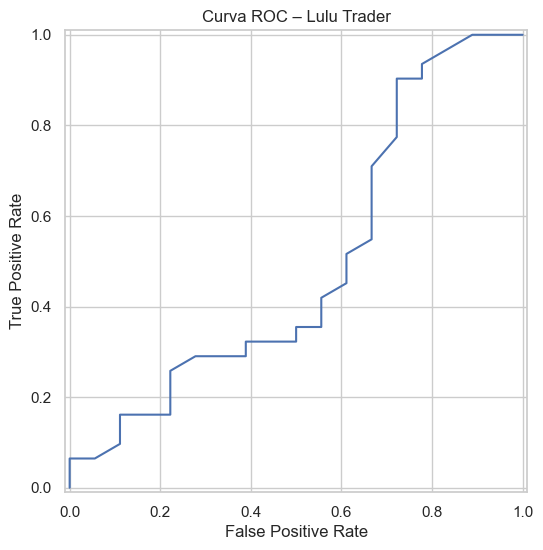

In [167]:
# Adiciona Matriz de confusão
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
plt.title("Matriz de Confusão – Lulu Trader")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, probas)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("Curva ROC – Lulu Trader")
plt.grid(True)
plt.show()

In [168]:
# Junta X e y num DataFrame só
df_model = df[features + ["target"]].copy()

# Separar por classe
df_0 = df_model[df_model["target"] == 0]
df_1 = df_model[df_model["target"] == 1]

# Descobrir qual é a minoria
if len(df_0) > len(df_1):
    df_major = df_0
    df_minor = df_1
else:
    df_major = df_1
    df_minor = df_0

# Reamostrar (oversample da minoria para igualar com a maioria)
df_minor_upsampled = resample(
    df_minor,
    replace=True,
    n_samples=len(df_major),
    random_state=42
)

# Juntar tudo
df_balanced = pd.concat([df_major, df_minor_upsampled])

# Recriar X e y
X = df_balanced[features]
y = df_balanced["target"]

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Treinar modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Previsão com threshold ajustado
probas = modelo.predict_proba(X_test)[:,1]
y_pred = (probas > 0.5).astype(int)

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7192982456140351
              precision    recall  f1-score   support

           0       0.69      0.83      0.76        30
           1       0.76      0.59      0.67        27

    accuracy                           0.72        57
   macro avg       0.73      0.71      0.71        57
weighted avg       0.73      0.72      0.71        57



In [169]:
# Salvar modelo
joblib.dump(modelo, "models/lulu_model.pkl")

['models/lulu_model.pkl']

In [170]:
import os

# Garante que a pasta exista
os.makedirs("data/processed", exist_ok=True)

# Agora sim salva o CSV com todas as features
df.to_csv("data/processed/full_features.csv", index=False)
